In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

!sudo apt-get install -y xvfb ffmpeg
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install gast

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

import base64
import imageio
import IPython
import numpy as np
import PIL.Image
import pyvirtualdisplay

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# OpenAi Gym

[OpenAI Gym](https://github.com/openai/gym) is a toolkit for developing and comparing reinforcement learning algorithms.  It includes a growing collection of
benchmark problems that expose a common interface, and a [website](https://github.com/openai/gym/wiki/Leaderboard) where people can share their results
and compare the performance of algorithms.

Gym, allows us to simulate a defined environment in the presence of an agent that we define, where the agent sends actions to the environment, and the environment replies with observations and rewards (that is, a score). The following are the environment object (`Env`) has the following useful methods:
* `reset()`: Reset the environment's state. Returns observation.
* `step(action)`: Step the environment by one timestep. Returns observation, reward, done, info.
* `render(mode='human')`: Render one frame of the environment. The default mode will do something human friendly, such as pop up a window.

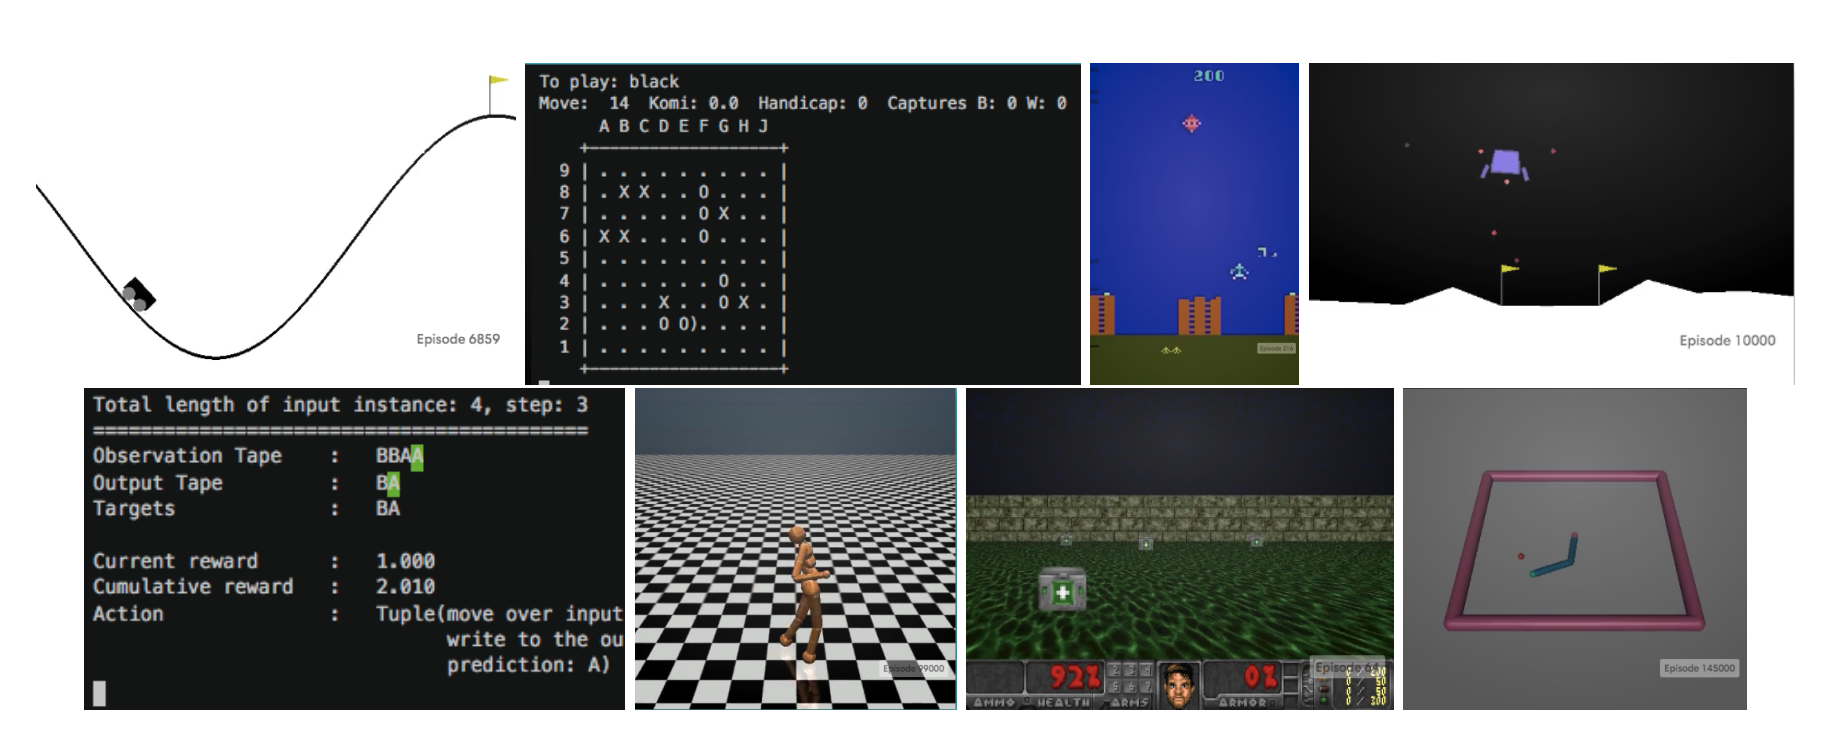
[[1](https://arxiv.org/abs/1606.01540)]

> A selection of the possible environemnts rendered


# Reinforcement Learning

Reinforcement learning (RL) is a general framework where agents learn to perform actions in an environment so as to maximize a reward. The two main components are the environment, which represents the problem to be solved, and the agent, which represents the learning algorithm.

The agent and environment continuously interact with each other. At each time step, the agent takes an action on the environment based on its *policy* $\pi(a_t|s_t)$, where $s_t$ is the current observation from the environment, and receives a reward $r_{t+1}$ and the next observation $s_{t+1}$ from the environment. The goal is to improve the policy so as to maximize the sum of rewards (return).


## The Cartpole Environment

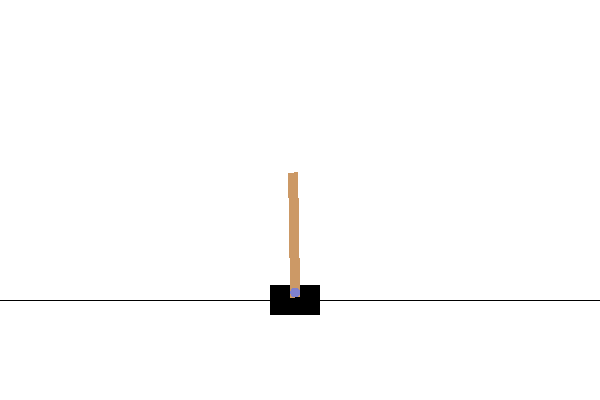

The Cartpole environment is one of the most well known classic reinforcement learning problems. A pole is attached to a cart, which can move along a frictionless track. The pole starts upright and the goal is to prevent it from falling over by controlling the cart.  

*   The observation from the environment $s_t$ is a 4D vector representing the position and velocity of the cart, and the angle and angular velocity of the pole. 
*   The agent can control the system by taking one of 2 actions $a_t$: push the cart right (+1) or left (-1). 
*   A reward $r_{t+1} = 1$ is provided for every timestep that the pole remains upright. The episode ends when one of the following is true:
  * the pole tips over some angle limit
  * the cart moves outside of the world edges
  * 200 time steps pass. 

The goal of the agent is to learn a policy $\pi(a_t|s_t)$ so as to maximize the sum of rewards in an episode $\sum_{t=0}^{T} \gamma^t r_t$. Here $\gamma$ is a discount factor in $[0, 1]$ that discounts future rewards relative to immediate rewards. This parameter helps us focus the policy, making it care more about obtaining rewards quickly.


## The DQN Agent

The  [DQN (Deep Q-Network) algorithm](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) was developed by DeepMind in 2015. It was able to solve a wide range of Atari games (some to superhuman level) by combining reinforcement learning and deep neural networks at scale. The algorithm was developed by enhancing a classic RL algorithm called Q-Learning with deep neural networks and a technique called *experience replay*.

### Q-Learning

Q-Learning is based on the notion of a Q-function. The Q-function (a.k.a the state-action value function) of a policy $\pi$, $Q^{\pi}(s, a)$, measures the expected return or discounted sum of rewards obtained from state $s$ by taking action $a$ first and following policy $\pi$ thereafter. We define the optimal Q-function $Q^*(s, a)$ as the maximum return that can be obtained starting from observation $s$, taking action $a$ and following the optimal policy thereafter. The optimal Q-function obeys the following *Bellman* optimality equation: 

$\begin{equation}Q^*(s, a) = \mathbb{E}\left[ r + \gamma \max_{a'} Q^*(s', a') \right]\end{equation}$

This means that the maximum return from state $s$ and action $a$ is the sum of the immediate reward $r$ and the return (discounted by $\gamma$) obtained by following the optimal policy therafter until the end of the episode (i.e., the maximum reward from the next state $s'$). The expectation is computed both over the distribution of immediate rewards $r$ and possible next states $s'$.

The basic idea behind Q-Learning is to use the Bellman optimality equation as an iterative update $Q_{i+1}(s, a) \leftarrow \mathbb{E}\left[ r + \gamma \max_{a'} Q_{i}(s', a')\right]$, and it can be shown that this converges to the optimal $Q$-function, i.e. $Q_i \rightarrow Q^*$ as $i \rightarrow \infty$ (see the [DQN paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)).


### Deep Q-Learning

For most problems, it is impractical to represent the $Q$-function as a table containing values for each combination of $s$ and $a$. Instead, we train a function approximator, such as a neural network with parameters $\theta$, to estimate the Q-values, i.e. $Q(s, a; \theta) \approx Q^*(s, a)$. This can done by minimizing the following loss at each step $i$:

$\begin{equation}L_i(\theta_i) = \mathbb{E}_{s, a, r, s'\sim \rho(.)} \left[ (y_i - Q(s, a; \theta_i))^2 \right]\end{equation}$ where $y_i = r +  \gamma \max_{a'} Q(s', a'; \theta_{i-1})$

Here, $y_i$ is called the TD (temporal difference) target, and $y_i - Q$ is called the TD error. $\rho$ represents the behaviour distribution, the distribution over transitions $\{s, a, r, s'\}$ collected from the environment. 

Note that the parameters from the previous iteration $\theta_{i-1}$ are fixed and not updated. In practice we use a snapshot of the network parameters from a few iterations ago instead of the last iteration. This copy is called the *target network*.

Q-Learning is an *off-policy* algorithm that learns about the greedy policy $a = \max_{a} Q(s, a; \theta)$ while using a different behaviour policy for acting in the environment/collecting data. This behaviour policy is usually an $\epsilon$-greedy policy that selects the greedy action with probability $1-\epsilon$ and a random action with probability $\epsilon$ to ensure good coverage of the state-action space.

### Experience Replay

To avoid computing the full expectation in the DQN loss, we can minimize it using stochastic gradient descent. If the loss is computed using just the last transition $\{s, a, r, s'\}$, this reduces to standard Q-Learning. 

The Atari DQN work introduced a technique called Experience Replay to make the network updates more stable. At each time step of data collection, the transitions are added to a circular buffer called the *replay buffer*. Then during training, instead of using just the latest transition to compute the loss and its gradient, we compute them using a mini-batch of transitions sampled from the replay buffer. This has two advantages: better data efficiency by reusing each transition in many updates, and better stability using uncorrelated transitions in a batch.


## DQN on Cartpole in TF-Agents

TF-Agents provides all the components necessary to train a DQN agent, such as the agent itself, the environment, policies, networks, replay buffers, data collection loops, and metrics. These components are implemented as Python functions or TensorFlow graph ops, and we also have wrappers for converting between them. Additionally, TF-Agents supports TensorFlow 2.0 mode, which enables us to use TF in imperative mode. 

## Setup

In [2]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

## Hyperparameters

In [3]:
num_iterations = 20000 # integer

initial_collect_steps = 1000  # integer
collect_steps_per_iteration = 1  # integer
replay_buffer_max_length = 100000  # integer

batch_size = 64  # integer
learning_rate = 1e-3  # integer
log_interval = 200  # integer

num_eval_episodes = 10  # integer
eval_interval = 1000  # integer

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

We can load the [CartPole](https://gym.openai.com/envs/CartPole-v1/) environment from the OpenAI Gym suite. [[2](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial)]

In [4]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

We can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

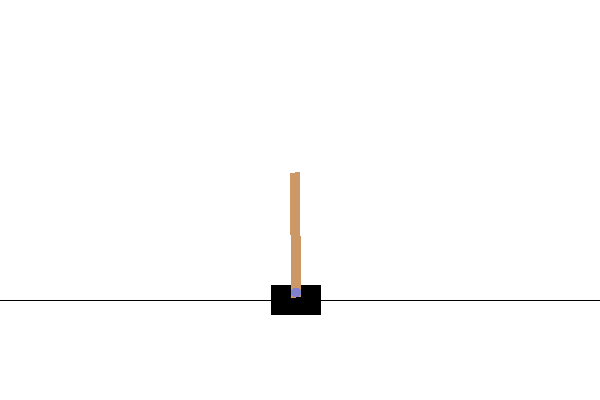

In [5]:
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [6]:
print('Observation Spec:\n')
print(env.time_step_spec().observation)

Observation Spec:

BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [7]:
print('Reward Spec:\n')
print(env.time_step_spec().reward)

Reward Spec:

ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [8]:
print('Action Spec:\n')
print(env.action_spec())

Action Spec:

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"


In [9]:
time_step = env.reset()
print('Time step: ', time_step)

action = np.array(1, dtype=np.int32)
print()

next_time_step = env.step(action)
print('Next time step: ', next_time_step)

Time step:  TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04775956, -0.04301015, -0.00909134, -0.01940907], dtype=float32))

Next time step:  TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([ 0.04689936,  0.15224099, -0.00947952, -0.3149465 ], dtype=float32))


Usually two environments are instantiated: one for training and one for evaluation. 

In [10]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [11]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (we will be using now)
-   [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290).

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

Use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple describing the number and size of the model's hidden layers.


In [12]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [13]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

Here, the desired outcome is keeping the pole balanced upright over the cart and the policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

* `agent.policy` — The main policy that is used for evaluation and deployment.
* `agent.collect_policy` — A second policy that is used for data collection.


In [14]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [15]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [16]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [17]:
time_step = example_environment.reset()

In [18]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [19]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [20]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

20.9

## Replay Buffer

The replay buffer keeps track of data collected from the environment. Here we will use `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.


In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [22]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [23]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [24]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer, steps=100)

The replay buffer is now a collection of Trajectories.

In [25]:
# For example
iter(replay_buffer.as_dataset()).next()

(Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.02879852,  1.1378474 , -0.09731118, -1.7903591 ], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=1>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>),
 BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=10>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>))

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [26]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [27]:
iterator = iter(dataset)

print(iterator)


In [28]:
# For example
iterator.next()

(Trajectory(step_type=<tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[2, 0],
        [1, 1],
        [1, 1],
        [2, 0],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 2],
        [1, 2],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [0, 1],
        [1, 2],
        [1, 1],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 2],
        [1, 1],
        [1, 1],
   

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

Here we also periodically evaluate the policy and prints the current score.

In [29]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 8.559625625610352
step = 400: loss = 15.810648918151855
step = 600: loss = 2.0140914916992188
step = 800: loss = 3.263287305831909
step = 1000: loss = 7.075463771820068
step = 1000: Average Return = 38.599998474121094
step = 1200: loss = 13.982575416564941
step = 1400: loss = 36.949989318847656
step = 1600: loss = 16.761756896972656
step = 1800: loss = 28.240623474121094
step = 2000: loss = 69.74480438232422
step = 2000: Average Return = 60.400001525878906
step = 2200: loss = 76.28549194335938
step = 2400: loss = 55.14008712768555
step = 2600: loss = 32.62689208984375
step = 2800: loss = 39.97493362426758
step = 3000: loss = 29.541561126708984
step = 3000: Average Return = 63.0
step = 3200: loss = 81.79151916503906
step = 3400: loss = 69.63524627685547
step = 3600: loss = 130.49368286132812
step = 3800: loss = 23.25162124633789
step = 4000: loss = 34.55213928222656
step = 4000: Average Return = 150.60000610351562
step = 4200: loss = 4.697242259979248
step = 4400: los

## Visualization


### Plots

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-0.025000000000000355, 250)

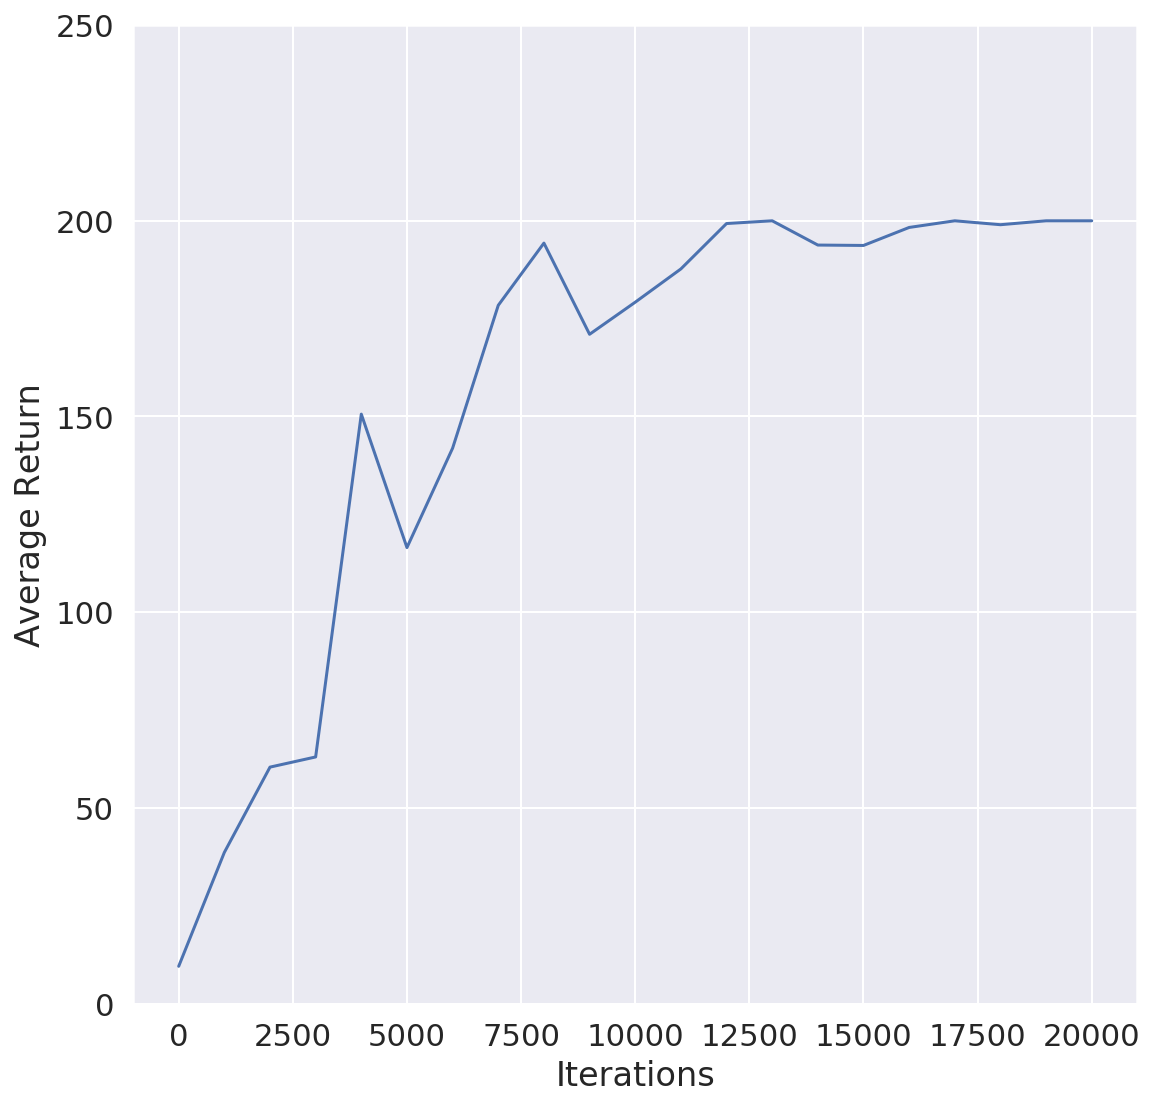

In [30]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [31]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [32]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


create_policy_eval_video(agent.policy, "cartpole-dqn-trained-agent")

For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [33]:
create_policy_eval_video(random_policy, "cartpole-dqn-random-agent")